In [1]:
import numpy as np
import h5py
import os
import pydicom
import pandas as pd
import math
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from itertools import compress
from scipy import ndimage
from functions.data_import import *
from functions.plot_sequence import *
from functions.config import *

## Config variables

stored in functions/config.py

# Create image info file
only needs to be done once, file is stored in PATH_IMAGE_INFO

In [2]:
# rename_folders_to_3char(PATH_DICOM)

In [3]:
# create_file_list(PATH_DICOM, PATH_IMAGE_INFO)

## Functions

are saved in seperate files

## Import Baseline Dataset

In [4]:
baseline_data = pd.read_csv(PATH_BASELINE, sep = " ")
baseline_data.p_id = [format(id, '03d') for id in baseline_data.p_id] 
# baseline_data.p_id

FileNotFoundError: [Errno 2] No such file or directory: '../data/baseline_data_DWI.csv'

## Load all paths to images

In [5]:
data_info = pd.read_csv(PATH_IMAGE_INFO)
data_info.patient = [format(id, '03d') for id in data_info.patient] 
# data_info[data_info.patient == "211"]

FileNotFoundError: [Errno 2] No such file or directory: '../data/image_info.csv'

## Sequence Types

In [6]:
# set(data_info['sequence'])

In [7]:
# set(data_info['description'])

- Some Patients have the same description for two differnet sequences
- Sequence Types are unique (every sequence has a different name)
- But: Patient 4 lacks all Sequence Types
- Patient 8 has different names for sequence types

## Import DICOM images to h5

only needs to be done once, data is stored in PATH_2D_H5_RAW, images are scaled to 192x192x3 and the pixel value range is unchanged.

In [8]:
# dicom_2d_to_h5py(data_info, baseline_data)

Adding labels from the jpg dataset to the dicom images. Data is cleaned for inconsistancies between dicom and jpg. Information for cleaning the dataset is taken from the file PATH_CLEAN_UP.

In [9]:
# cleanup_2d_h5py()

In [6]:
with h5py.File(PATH_2D_H5_RAW, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)

OSError: Unable to open file (unable to open file: name = '../data/dicom_2d_192x192x3_raw.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
with h5py.File(PATH_2D_H5_CLEAN, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)

['X', 'Y', 'img_id', 'pat', 'path', 'stroke']
(13095, 192, 192, 3)


In [12]:
with h5py.File(PATH_JPG_H5, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)

['X', 'Y', 'img_id', 'pat', 'pat_3c', 'path', 'stroke']
(15214, 192, 192, 3)


# Plots

In [13]:
def load_image_from_dicom_h5(file, patient_nb):
    with h5py.File(file, 'r') as dd:
        patients = [p.decode() for p in dd['pat']]
        indices = [i for i, x in enumerate(patients) if x == patient_nb]
        mri = np.array(dd['X'][indices])
        labels = np.array(dd['Y'][indices])
    return mri, labels

def load_image_from_jpg_h5(file, patient_nb):
    with h5py.File(file, 'r') as dd:
        patients = [p.decode() for p in dd['pat_3c']]
        indices = [i for i, x in enumerate(patients) if x == patient_nb]
        mri = np.array(dd['X'][indices])
        labels = np.array(dd['Y'][indices])
    return mri, labels

def load_3D_from_h5(patient_nb):
    dd = h5py.File(PATH_3D_H5, 'r')
    patients = [p.decode() for p in dd['pat']]

    mri = np.array(dd['X'])[patients.index(patient_nb), :, :, :]
    return mri.reshape(IMAGE_DIMENSIONS_3D)

def load_file_list(patient_nb):
    with h5py.File(PATH_IMAGE_INFO, 'r') as dd:
        patients = [p.decode() for p in dd['pat']]
        indices = [i for i, x in enumerate(patients) if x == patient_nb]
        file_list = [p.decode() for p in (dd['path'][indices])]
    return file_list

In [14]:
def load_images_3D(file_list):

    ## loads DICOM images from file_list and creates a 3D array with pixel data
    ref_file = pydicom.read_file(file_list[0])
    image_dims_3d = (len(file_list), int(ref_file.Rows), int(ref_file.Columns), )
    # print("Original image size: {}".format(image_dims_3d))

    origArray = np.zeros(image_dims_3d, dtype=ref_file.pixel_array.dtype)

    # loop through all the DICOM files
    removed = 0
    file_list.sort()
    for filename in file_list:
        # read the file
        ds = pydicom.read_file(filename)
        # store the raw image data

        if(ds.Rows != ref_file.Rows):
            removed  += 1
            continue

        origArray[file_list.index(filename), :, :] = ds.pixel_array

    if(removed != 0):
        print('removed {} files for sequence {}'.format(removed, ref_file.SequenceName))
    origArray = normalize_array(origArray)
    origArray = np.stack((origArray, origArray, origArray), axis=3)

    return origArray

In [58]:
def plot_mri(data, label, id, vmax = False):

    n_rows = 6
    n_cols = 5
    aspect_ratio = 1
    base_size = 4
    fig_size = (n_cols*base_size/aspect_ratio, n_rows*base_size)
    fig = plt.figure(figsize=fig_size)
    
    data = normalize_array(data)

    sp = 1
    for index in range(n_cols * n_rows):
        try:
            image = data[index, :, :, :]
            y = label[index]
        except:
            image = np.zeros((192, 192, 3))
            y = ""

        ax = fig.add_subplot(n_rows, n_cols, sp)
        if vmax:
            ax.imshow(image, vmin = 0, vmax = vmax)
        else:
            ax.imshow(image)
        if sp == 1:
            ax.text(10, 40, id, fontsize = 50, color = "w")
        ax.text(160, 180, y, fontsize = 30, color = "w")
        ax.set_aspect('equal', 'box')
        ax.set_axis_off()
        sp += 1
        
    fig.tight_layout(pad=0.0)
    p = '../MRIs/{}_jpg.png'.format(id)
    fig.savefig(p)

In [23]:
def plot_compare(data_dicom, data_jpg, label_dicom, label_jpg, id, vmax = False, skip = 0):

    data_jpg = normalize_array(data_jpg)
    data_dicom = normalize_array(data_dicom)
    n_slices_dicom = data_dicom.shape[0]
    n_slices_jpg = data_jpg.shape[0]

    n_cols = max(n_slices_dicom, n_slices_jpg)
    n_rows = 2
    aspect_ratio = 1
    base_size = 2
    fig_size = (n_cols*base_size/aspect_ratio, n_rows*base_size)
    fig = plt.figure(figsize=fig_size)

    sp = 1
    for index in range(max(n_slices_dicom, n_slices_jpg)):
        try:
            image_dicom = data_dicom[index, :, :, :]
            y_dicom = label_dicom[index]
        except:
            image_dicom = np.zeros((192, 192, 3))
            y_dicom = ""
        try:
            image_jpg = data_jpg[index - skip, :, :, :]
            y_jpg = label_jpg[index - skip]
        except:
            image_jpg = np.zeros((192, 192, 3))
            y_jpg = ""

        ax = fig.add_subplot(n_rows, n_cols, sp+n_cols)
        if vmax:
            ax.imshow(image_dicom, vmin = 0, vmax = vmax)
        else:
            ax.imshow(image_dicom)
        ax.text(160, 180, y_dicom, fontsize = 15, color = "w")
        ax.set_aspect('equal', 'box')
        ax.set_axis_off()

        ax = fig.add_subplot(n_rows, n_cols, sp)
        if vmax:
            ax.imshow(image_jpg, vmin = 0, vmax = vmax)
        else:
            ax.imshow(image_jpg)
        if sp == 1:
            ax.text(10, 40, id, fontsize = 25, color = "w")
        ax.text(150, 30, index, fontsize = 15, color = "r")
        ax.text(160, 180, y_jpg, fontsize = 15, color = "w")
        ax.set_aspect('equal', 'box')
        ax.set_axis_off()
        
        sp += 1

    fig.tight_layout(pad=0.0)
    #p = '../MRIs/{}_dicom.png'.format(id)
    #ig.savefig(p)

# Plotting data from JPG dataset 

In [59]:
p = "030"
mri_jpg, label_jpg = load_image_from_jpg_h5(PATH_JPG_H5, patient_nb = p)
print(mri_jpg.shape)

(28, 192, 192, 3)


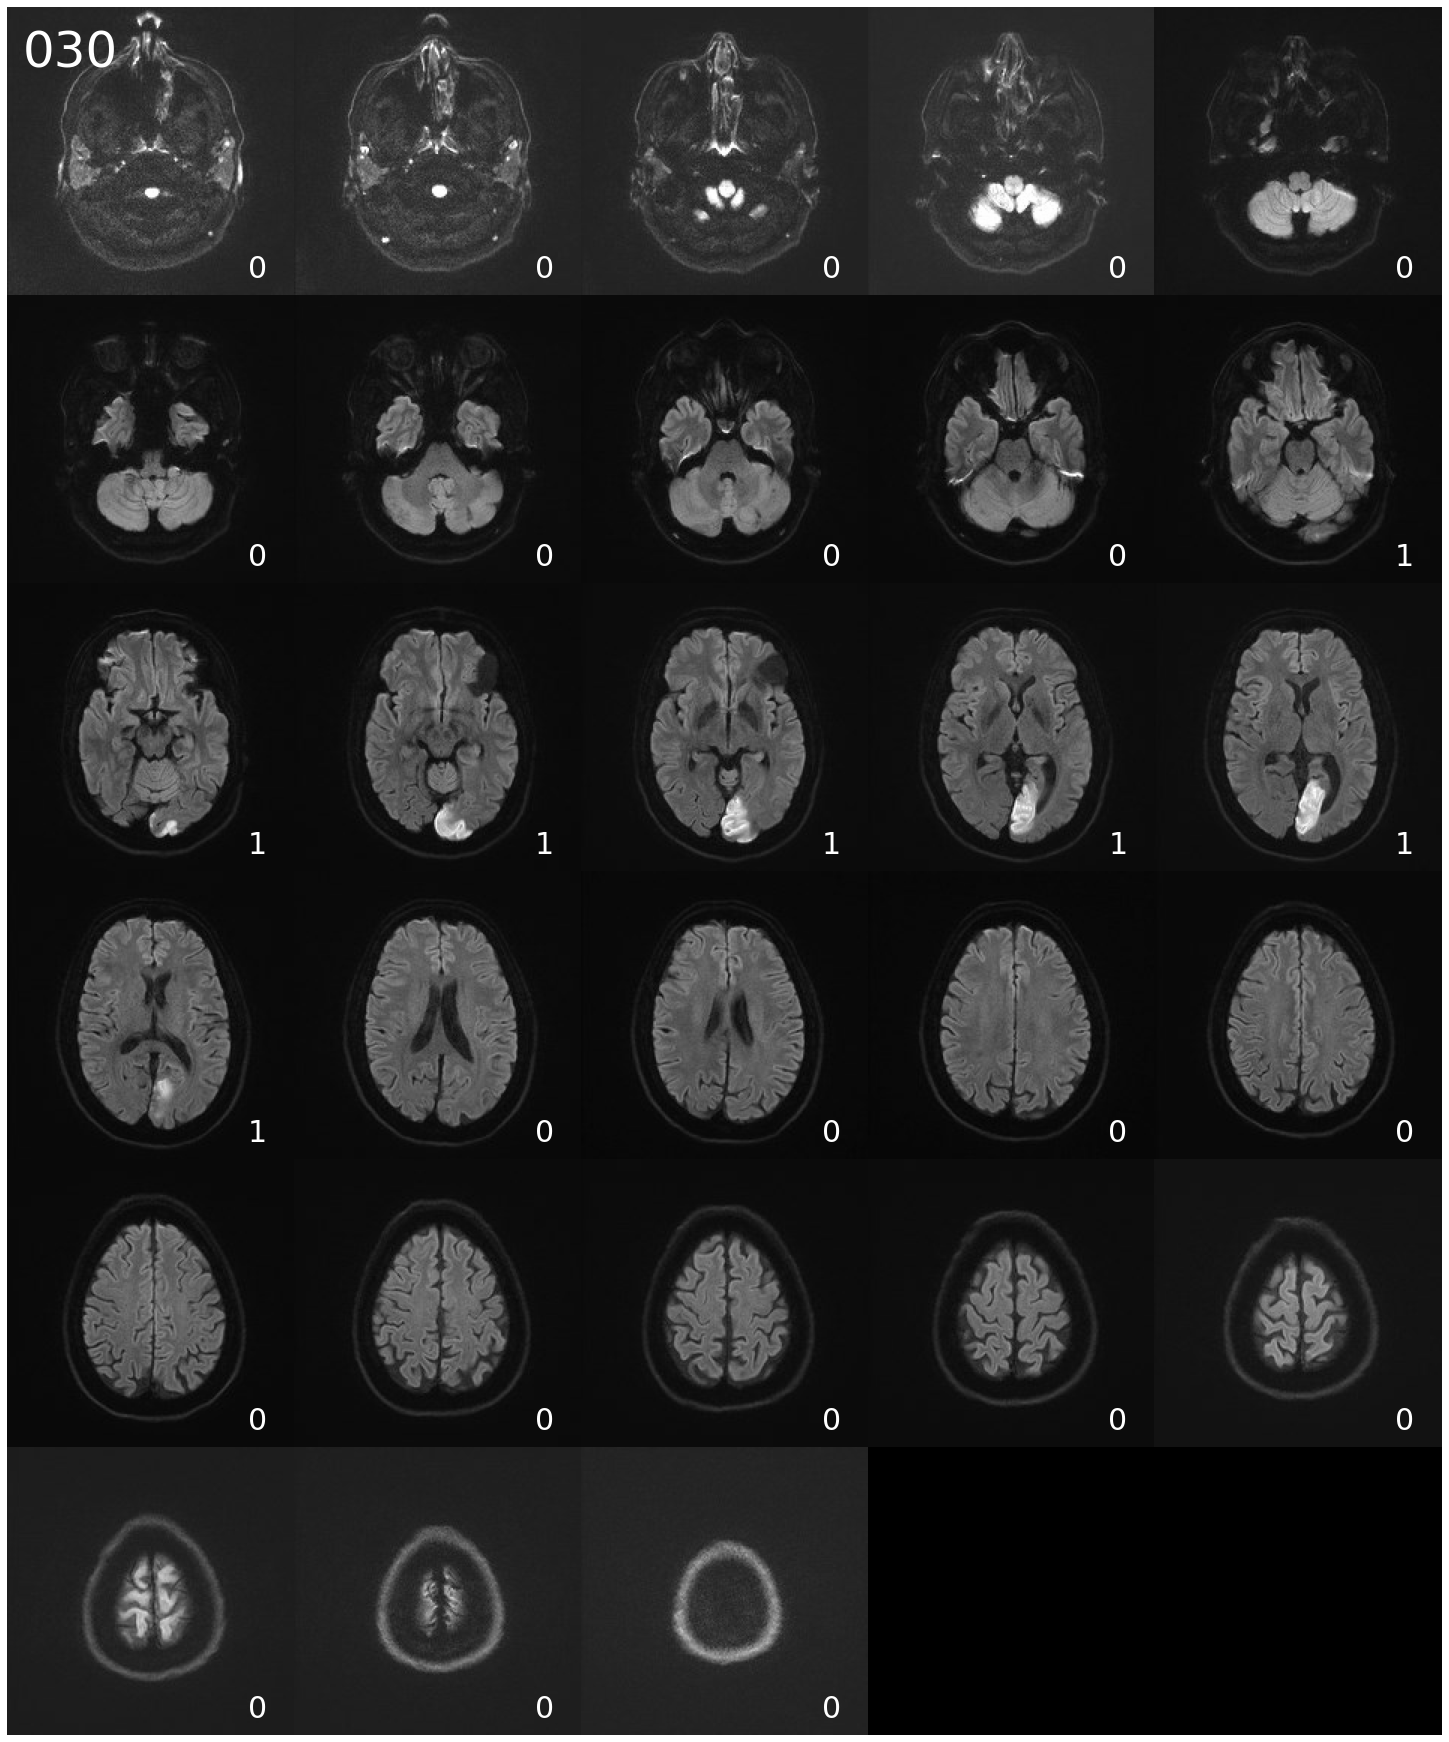

In [60]:
plot_mri(mri_jpg, label_jpg, p, vmax = False)

# Plotting data from DICOM dataset

In [52]:
p = "030"
dataset = PATH_2D_H5_CLEAN
# dataset = PATH_2D_H5_RAW
mri_dicom, label_dicom = load_image_from_dicom_h5(dataset, patient_nb = p)
print(mri_dicom.shape)

(28, 192, 192, 3)


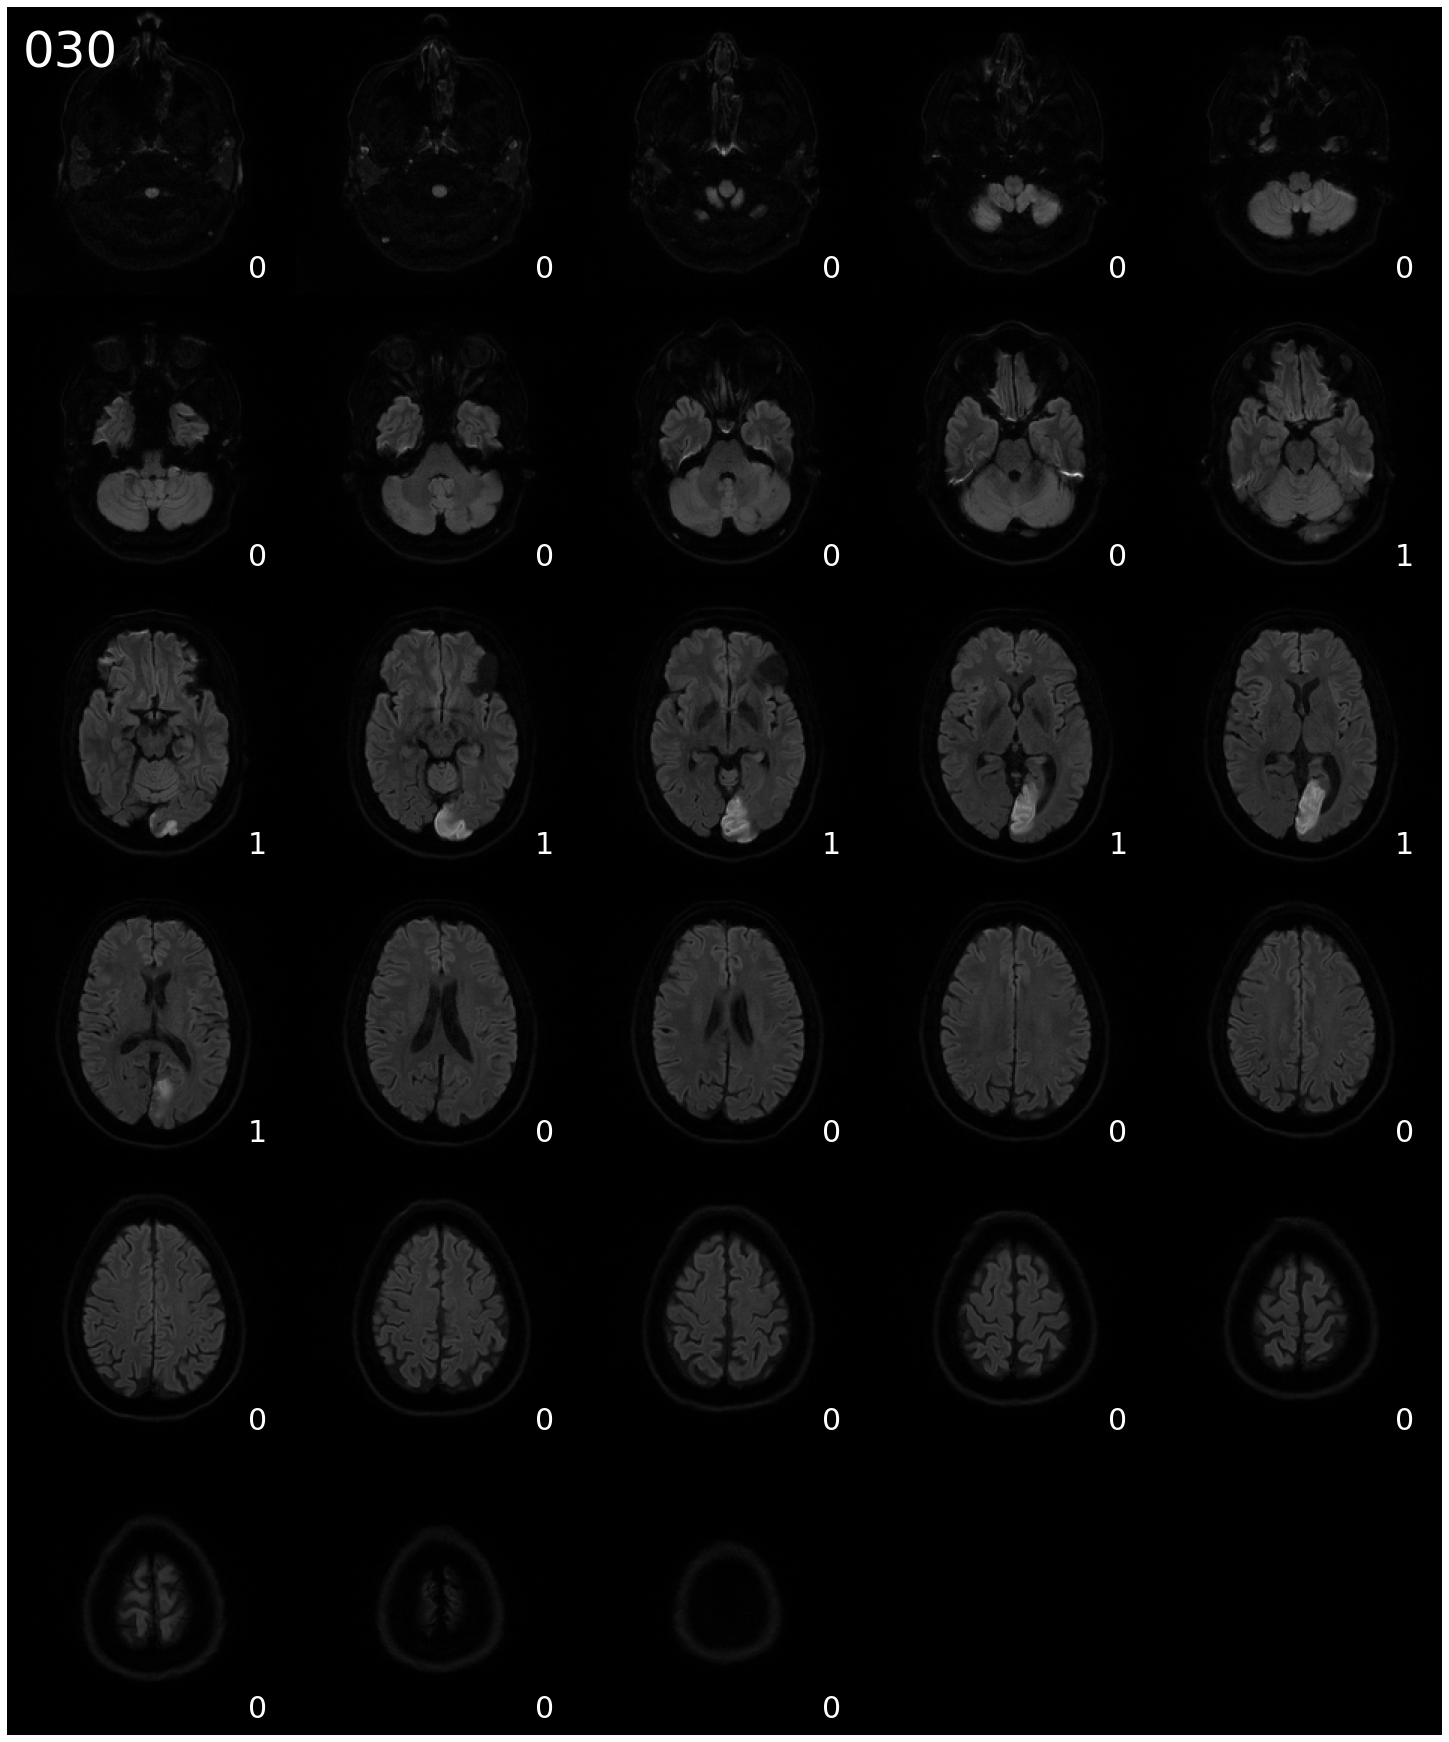

In [57]:
plot_mri(mri_dicom, label_dicom, p, vmax = 5000)

# Comparing DICOM and JPG dataset

In [ ]:
p = '005'
dataset = PATH_2D_H5_CLEAN
# dataset = PATH_2D_H5_RAW
mri_dicom, label_dicom = load_image_from_dicom_h5(dataset, patient_nb = p)
mri_jpg, label_jpg = load_image_from_jpg_h5(PATH_JPG_H5, patient_nb = p)
print(mri_dicom.shape)
print(mri_jpg.shape)
plot_compare(mri_dicom, mri_jpg, label_dicom, label_jpg, p, skip = 0)